# _Cassia_ data re-analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
import pathlib

try:
    # if on colab
    from google.colab import drive, files
    drive.mount('/content/drive')

    DRIVEDIR = pathlib.Path('drive/Shareddrives/mmWave Drive')

    !pip install uncertainties
    !pip install scikit-rf
except ModuleNotFoundError:
    # if not on colab
    DRIVEDIR = pathlib.Path('../../../../..')

DATADIR = DRIVEDIR / 'Data'

In [3]:
import copy
import itertools
import pickle

import h5py
import matplotlib.pyplot as plt
import numpy as np
import skrf as rf
import uncertainties
from scipy.constants import c, pi
from uncertainties import ufloat
from uncertainties import unumpy as unp

In [5]:
from suprtools.fp_theory.geometry import SymmetricCavityGeometry
# from suprtools.fp_theory.coupling import CouplingConfig
# from suprtools.fp_theory.modes import ScalarModeBasis
from suprtools.plotting import sslab_style
from suprtools.rf import WideScanData, Ringdown, fit_mode, test_a_fit, FabryPerotModeParams, ModeMaskingPolicy

In [15]:
mirror_test_dir = DATADIR / pathlib.Path('Mirror tests')
caecilia_data_dir = mirror_test_dir / 'Caecilia'
cassia_data_dir = mirror_test_dir / 'Cassia'
domitia_data_dir = mirror_test_dir / 'Domitia'
egnatia_data_dir = mirror_test_dir / 'Egnatia'

In [9]:
def load_all_windows(directory, name: str):
    dirpath = pathlib.Path(directory)
    return tuple(
        WideScanData.from_window(h5_path, name, sample_temps=True)
        for h5_path in sorted(list(dirpath.glob('*.h5')))
    )

In [16]:
narrow_scan_dir = cassia_data_dir / '20230721-narrow-sweeps'
narrow_30mw_dir = cassia_data_dir / '20230724-narrow-sweeps-30mw'
narrow_110mw_dir = cassia_data_dir / '20230726-narrow-sweeps-110mw-turbo-off'

In [17]:
vna_data_0mw = load_all_windows(narrow_scan_dir, '7/21 narrow scans')
vna_data_30mw = load_all_windows(narrow_30mw_dir, '7/24 30 mW scans')
vna_data_110mw = load_all_windows(narrow_110mw_dir, '7/26 110 mW scans')
vna_data = [vna_data_0mw, vna_data_30mw, vna_data_110mw]

In [ ]:
fit_params_1k

[[[(77.1123, 5, 3),
   (80.53896, 5, 3),
   (83.96562, 5, 3),
   (87.3924, 5, 3),
   (90.81805, 10, 5),
   (94.24486, 0.8, 2),
   (97.67145, 7, 3),
   (101.09796, 0.4, 2),
   (104.52444, 0.4, 2),
   (107.9509, 0.4, 2)],
  [(77.11286, 5, 4),
   (80.5395, 5, 3),
   (83.96614, 5, 3),
   (87.39287, 5, 3),
   (90.81851, 10, 5),
   (94.24533, 0.5, 2),
   (97.67189, 7, 3),
   (101.09839, 0.4, 2),
   (104.52487, 0.4, 2),
   (107.95131, 0.4, 2)]],
 [[None, None, None, None, (90.82038, 7, 5), None, None, None, None, None],
  [None, None, None, None, None, None, None, None, None, None]],
 [[(77.11684, 8, 3),
   (80.545, 8, 2),
   (83.9727, 8, 3),
   (87.40035, 12, 3),
   (90.82792, 6, 3),
   (94.25535, 6, 3),
   (97.68269, 5, 4),
   (101.10995, 5, 3),
   (104.5371, 5, 3),
   (107.96424, 5, 3)],
  [(77.11696, 8, 3),
   None,
   (83.97285, 8, 3),
   (87.40057, 12, 3),
   (90.82812, 6, 3),
   (94.25554, 6, 3),
   (97.68289, 5, 4),
   (101.11014, 5, 3),
   (104.5373, 5, 3),
   (107.96443, 5, 3)]],
 [

In [18]:
fit_params_1k = [
    [
        [
            (77.11230, 5, 3),
            (80.53896, 5, 3),
            (83.96562, 5, 3),
            (87.39240, 5, 3),
            (90.81805, 10, 5),
            (94.24486, 0.8, 2),
            (97.67145, 7, 3),
            (101.09796, 0.4, 2),
            (104.52444, 0.4, 2),
            (107.95090, 0.4, 2),
        ],
        [
            (77.11286, 5, 4),
            (80.53950, 5, 3),
            (83.96614, 5, 3),
            (87.39287, 5, 3),
            (90.81851, 10, 5),
            (94.24533, 0.5, 2),
            (97.67189, 7, 3),
            (101.09839, 0.4, 2),
            (104.52487, 0.4, 2),
            (107.95131, 0.4, 2),
        ],
    ],
    ####
    [
        [
            None,
            None,
            None,
            None,
            (90.82038, 7, 5),
            None,
            None,
            None,
            None,
            None,
        ],
        [
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
        ],
    ],
    #### done thru here
    [
        [
            (77.11684, 8, 3),
            (80.54500, 8, 2),
            (83.97270, 8, 3),
            (87.40035, 12, 3),
            (90.82792, 6, 3),
            (94.25535, 6, 3),
            (97.68269, 5, 4),
            (101.10995, 5, 3),
            (104.53710, 5, 3),
            (107.96424, 5, 3),
        ],
        [
            (77.11696, 8, 3),
            None,
            (83.97285, 8, 3),
            (87.40057, 12, 3),
            (90.82812, 6, 3),
            (94.25554, 6, 3),
            (97.68289, 5, 4),
            (101.11014, 5, 3),
            (104.53730, 5, 3),
            (107.96443, 5, 3),
        ],
    ],
    #### done thru here
    [
        [
            (77.17183, 6, 3),
            (80.59820, 4, 3),
            (84.02458, 4, 3),
            None,
            (90.87730, 6, 4),
            (94.30365, 6, 3),
            (97.73004, 6, 3),
            None,
            (104.58280, 6, 3),
            (108.00920, 5, 4),
        ],
        [
            (77.17266, 6, 3),
            (80.59890, 4, 3),
            (84.02528, 4, 3),
            None,
            (90.87787, 6, 4),
            (94.30421, 6, 3),
            (97.73056, 6, 3),
            None,
            (104.58329, 6, 3),
            (108.00965, 5, 4),
        ],
    ],
]

In [19]:
with open(DRIVEDIR / 'Analysis/2023' / '20230724-4k-mode-poles.pickle', 'rb') as f:
    mode_poles_4k = pickle.load(f)

In [20]:
def t5_key(fit_data_tuple):
    pole, t5, tsamp = fit_data_tuple
    return t5

In [45]:
mode_fit_data = [
    [
        {
            mode_tuple[0]: [(pole_4k, 4.05, 4.16)]  # will be (pole, still_temp, sample_temp)
            for mode_tuple, pole_4k in zip(*mode_series) if mode_tuple is not None
        }
        for mode_series in zip(*multiplet_series)
    ]
    for multiplet_series in zip(fit_params_1k, mode_poles_4k)
]

for vna_data_single in itertools.chain(*vna_data):
    for i, multiplet_series in enumerate(fit_params_1k):
        for j, mode_series in enumerate(multiplet_series):
            for fit_param_onemode in mode_series:
                network = vna_data_single.s21
                if fit_param_onemode is None:
                    continue
                freq_ghz, span_mhz, n_poles_cmplx = fit_param_onemode
                if network.frequency.start > freq_ghz * 1e9:
                    continue
                if network.frequency.stop < freq_ghz * 1e9:
                    break

                pole_record = (ufloat(np.nan, np.nan),) * 4
                try:
                    vf = fit_mode(network, freq_ghz, span_mhz/1e3, n_poles_cmplx=n_poles_cmplx)
                    pole_record = vf.closest_pole_uparams(1e+9 * freq_ghz)
                except RuntimeError:
                    pass
                
                mode_fit_data[i][j][freq_ghz].append((
                    pole_record,
                    vna_data_single.metadata['t_plate'].item(),
                    vna_data_single.metadata['t_samp'].item(),
                ))
                
                
        #         mode_series_vfs.append(vf)
        #     multiplet_series_poles.append(mode_series_poles)
        #     multiplet_series_vfs.append(mode_series_vfs)
        # all_poles.append(multiplet_series_poles)
        # vfs.append(multiplet_series_vfs)

for mode_series in mode_fit_data:
    for pol_series in mode_series:
        for fit_data_tuples in pol_series.values():
            fit_data_tuples.sort(key=t5_key)

/Users/txz/Dropbox (Personal)/stanford/sslab/suprtools/build/__editable__.suprtools-2025.8.14-py3-none-any/suprtools/rf/freqdomain.py:1520: RuntimeWarning: Vector Fitting: The pole relocation process stopped after reaching the maximum number of iterations (N_max = 100). The results did not converge properly.
Hint: the linear system was ill-conditioned (max. condition number was 6.624128335718089e+18).
  vf.vector_fit(n_poles_real=0, n_poles_cmplx=n_poles_cmplx)
/Users/txz/Dropbox (Personal)/stanford/sslab/suprtools/build/__editable__.suprtools-2025.8.14-py3-none-any/suprtools/rf/freqdomain.py:1520: RuntimeWarning: Vector Fitting: The pole relocation process stopped after reaching the maximum number of iterations (N_max = 100). The results did not converge properly.
Hint: the linear system was ill-conditioned (max. condition number was 3.7983077438103706e+18).
  vf.vector_fit(n_poles_real=0, n_poles_cmplx=n_poles_cmplx)
/Users/txz/Dropbox (Personal)/stanford/sslab/suprtools/build/__edit

In [53]:
mode_fit_data_1k = copy.deepcopy(mode_fit_data)
for mode_series in mode_fit_data_1k:
    for pol_series in mode_series:
        for key, fit_data_tuples in pol_series.items():
            fit_data_tuples.sort(key=t5_key)
            pol_series[key] = fit_data_tuples[:-1]

In [54]:
with open('cassia-mode-fit-arr.pickle', 'wb') as f:
    pickle.dump(mode_fit_data_1k, f)

In [55]:
with open('cassia-mode-fit-arr.pickle', 'rb') as f:
    mode_fit_data_1k = pickle.load(f)

In [56]:
cassia_fsr = 3.42621675e+9

In [62]:
cassia_00_mode_params = dict()
for pol, mode_records in zip([+1, -1], mode_fit_data_1k[0]):
    for key, single_mode_records in mode_records.items():
        q = int(1e+9 * key / cassia_fsr)
        cassia_00_mode_params[(q, pol)] = FabryPerotModeParams(
            [[0., .030, .110]],
            [record for record, _, _ in single_mode_records],
            cassia_fsr,
        )

In [63]:
with open('cassia-00-mode-params.pickle', 'wb') as f:
    pickle.dump(cassia_00_mode_params, f)

In [ ]:
def coupling_strength_axs_setup(axs):
    axs[0].set_ylabel(
        r'Residue magnitude $|a|$''\n'r'[$2\pi \times$ Hz]'
    )
    axs[1].set_ylabel(r'$Q$-circle diameter $\frac{2|a|}{\kappa}$')
    axs[2].set_ylabel('Finesse')


def coupling_strength_plot(mode_params, masking_policy, axs, modelabel, **plot_kw):
    mode_info_masked = masking_policy.apply(mode_params)
    
    freq = np.nanmean(mode_info_masked.freqs)
    if not isinstance(freq, uncertainties.core.AffineScalarFunc):
        return
    
    mode_info_masked.errorbar_plot(
        mode_info_masked.res_mag,
        ax=axs[0],
        label=f'{modelabel} @ {freq.n/1e+9:10.6f} GHz',
        **plot_kw,
    )
    
    diam_abs = 2 * mode_info_masked.res_mag / mode_info_masked.fwhms
    mode_info_masked.errorbar_plot(
        diam_abs,
        ax=axs[1],
        **plot_kw,
    )

    finesses = mode_info_masked.finesses
    if not np.all(np.isnan(unp.nominal_values(finesses))):
        mode_info_masked.errorbar_plot(
            finesses,
            ax=axs[2],
            **plot_kw,
        )

In [ ]:
def mask_func(mode_info):
    return (
        np.isnan(unp.nominal_values(mode_info.freqs))
        | (unp.std_devs(mode_info.res_mag) > unp.nominal_values(mode_info.res_mag))
        | (np.arange(len(mode_info.params_arr)) > 20)
    )
# masking_policy = ModeMaskingPolicy(mask_func)
masking_policy = ModeMaskingPolicy.from_limits()

Text(0.5, 0, 'Heater power [mW]')

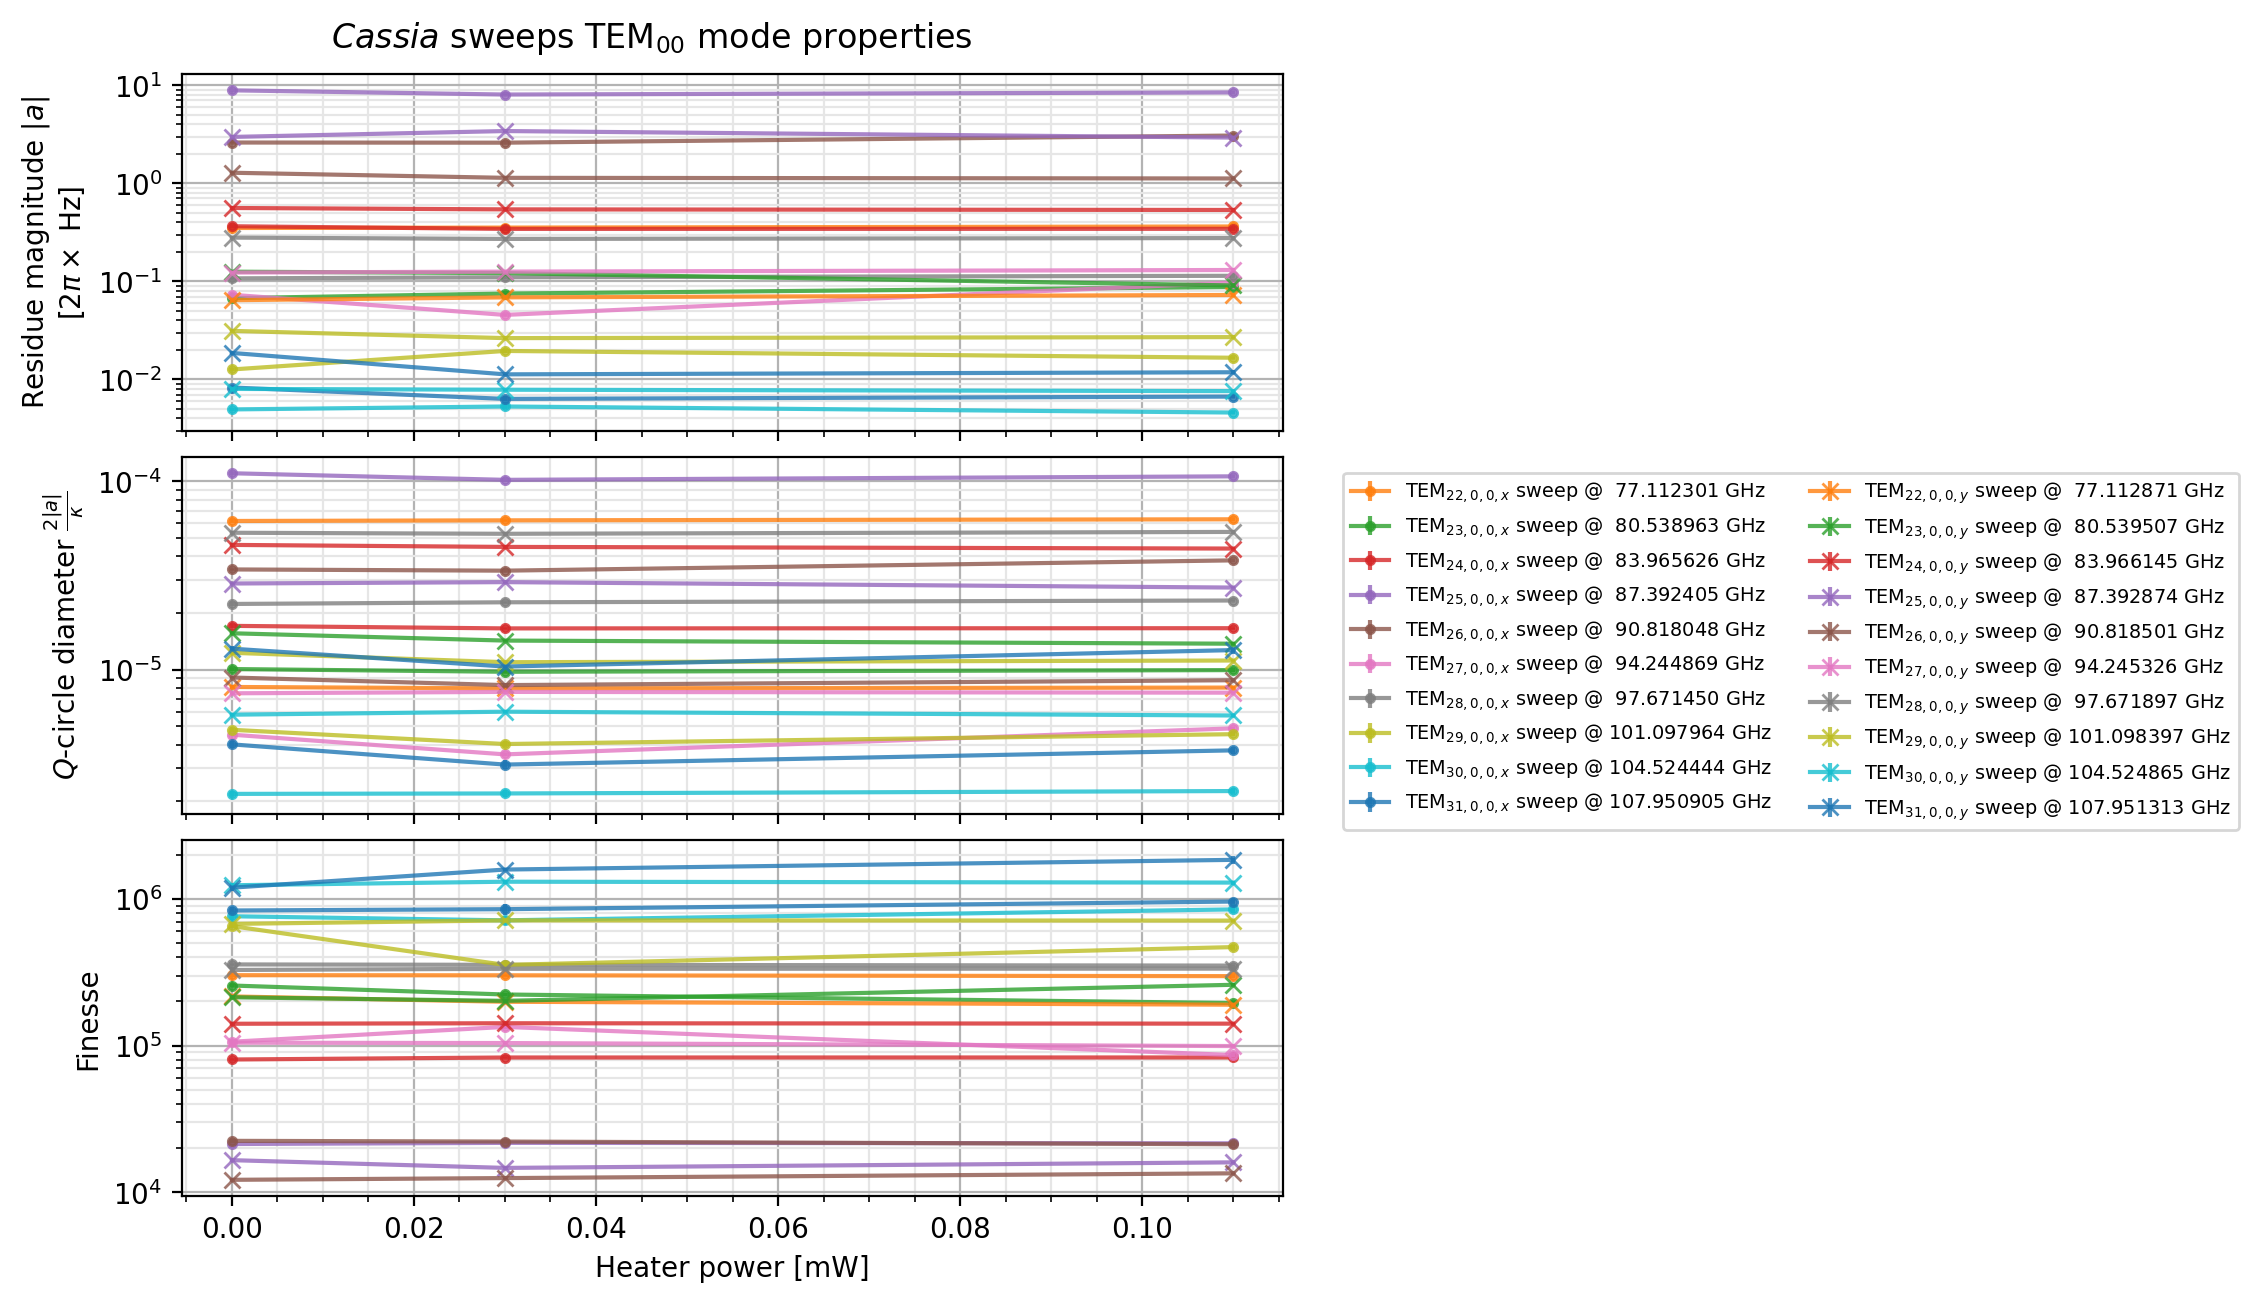

In [119]:
fig, axs = plt.subplots(figsize=(6.4, 6.4), nrows=3, sharex=True, layout='constrained')

for (q, pol), mode_info in cassia_00_mode_params.items():
    marker = '.' if pol == +1 else 'x'
    polstr = 'x' if pol == +1 else 'y'
    plot_kw = dict(
        remove_nans=True,
        marker=marker,
        color=f'C{q-21}',
        alpha=0.8
    )
    coupling_strength_plot(
        mode_info,
        masking_policy,
        axs,
        modelabel=f'TEM$_{{{q}, 0, 0, {polstr}}}$ sweep',
        **plot_kw,
    )

fig.legend(
    bbox_to_anchor=(1.04, 0.5),
    loc='center left',
    borderaxespad=0,
    ncol=2,
    fontsize='x-small',
)

for ax in axs:
    ax.set_yscale('log')
    sslab_style(ax)

fig.suptitle(r'$\it{Cassia}$ sweeps TEM$_{00}$ mode properties')
coupling_strength_axs_setup(axs)
# axs[2].set_ylim(1e+5, None)
axs[-1].set_xlabel('Heater power [mW]')

Text(0.5, 0, 'Heater power [mW]')

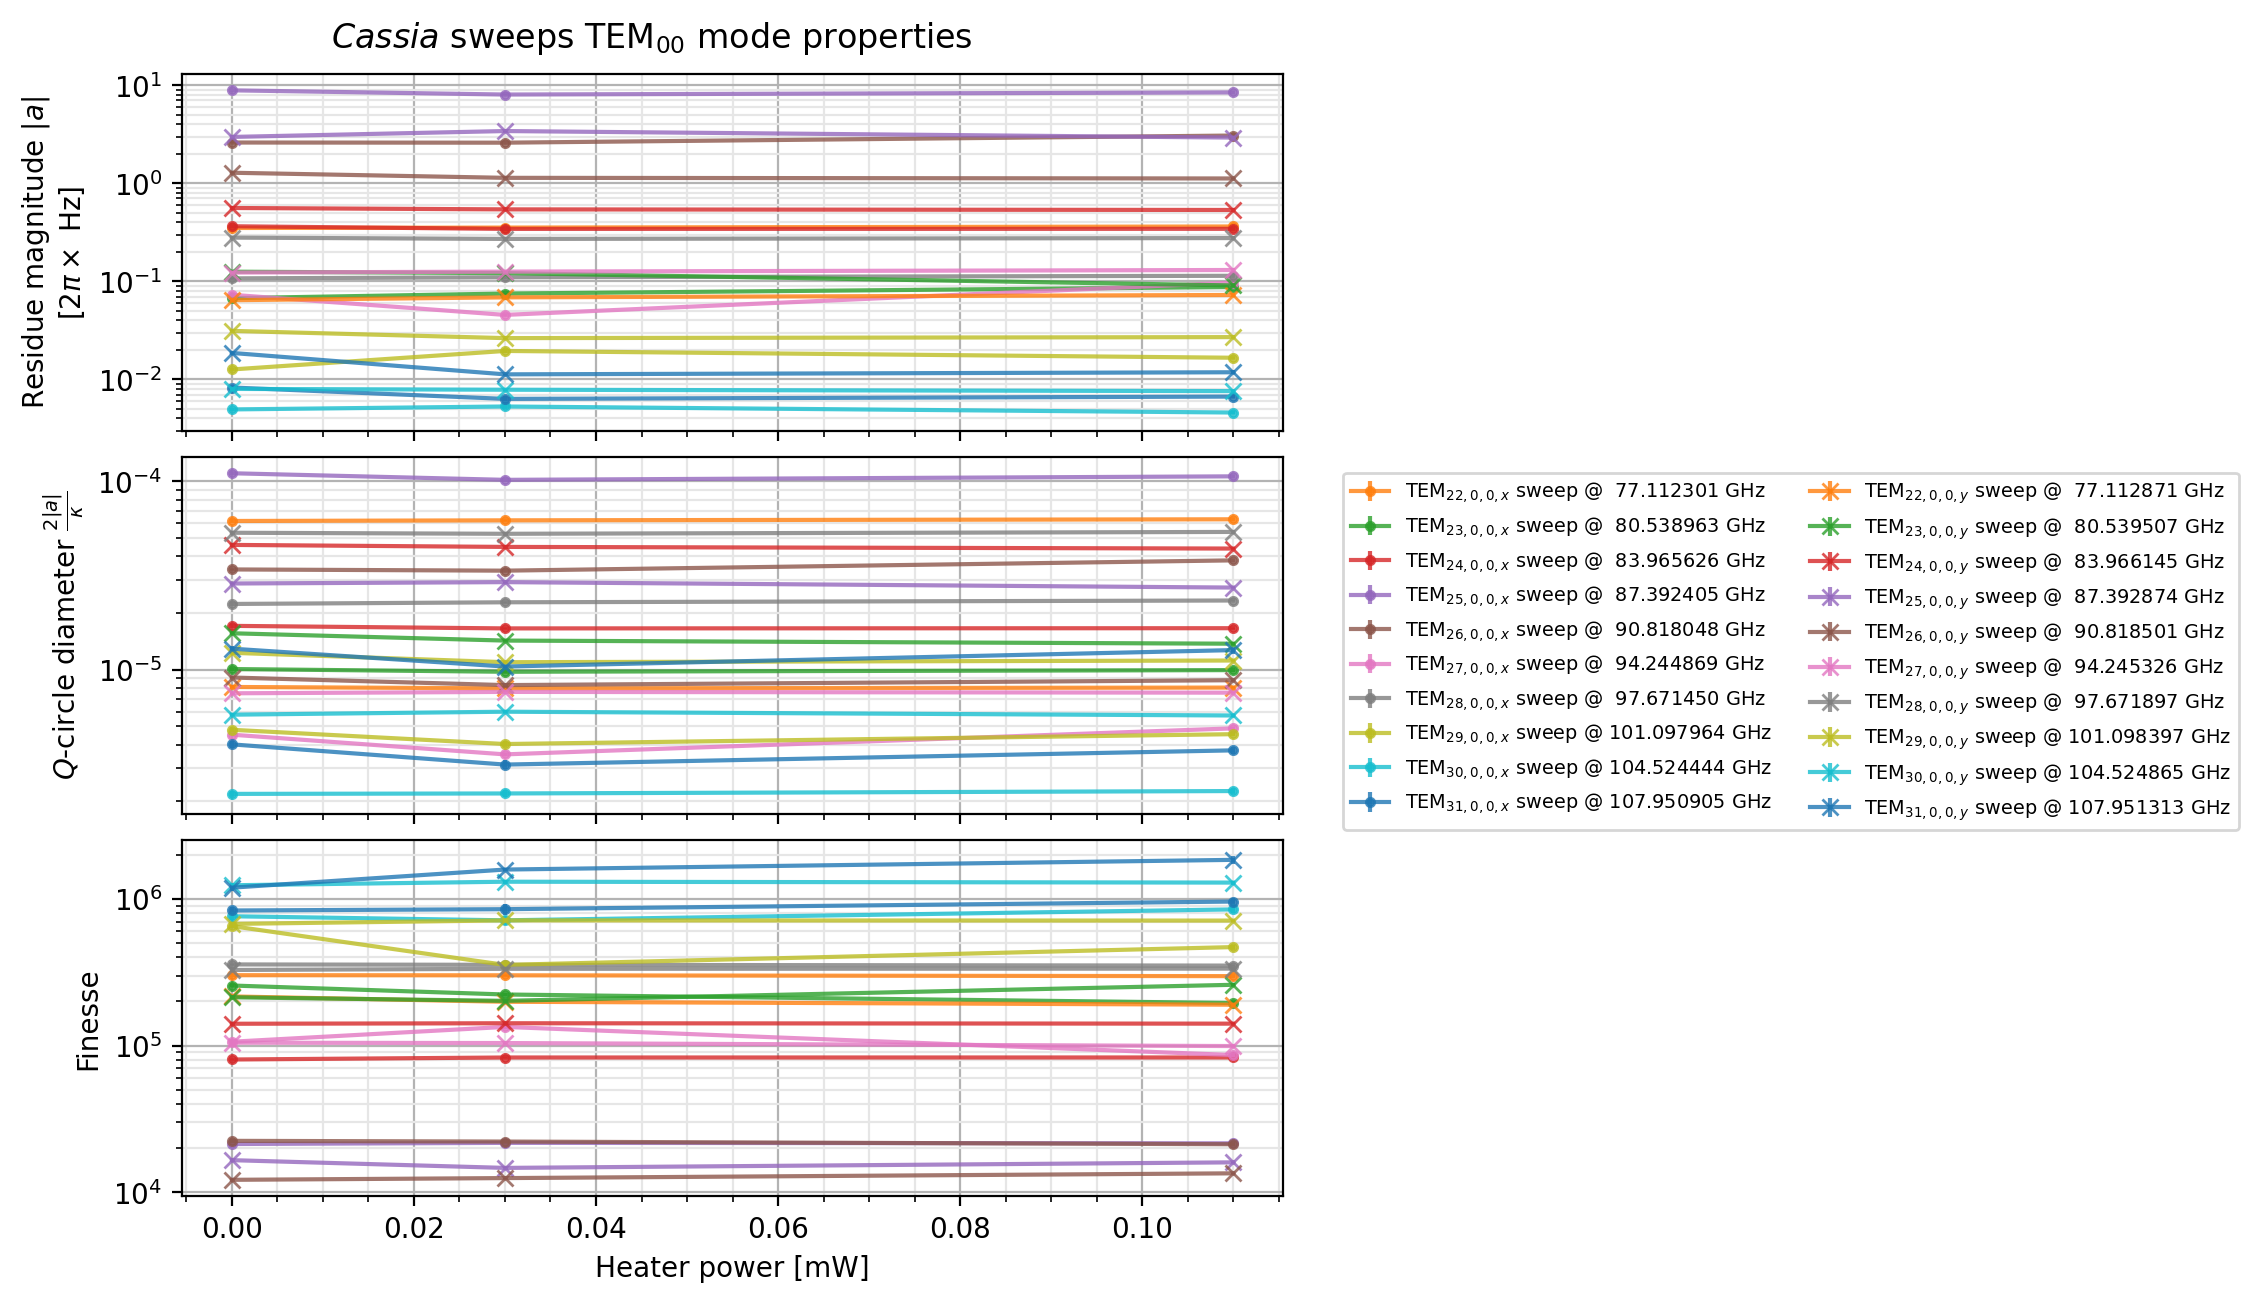

In [ ]:
fig, axs = plt.subplots(figsize=(6.4, 6.4), nrows=3, sharex=True, layout='constrained')

for (q, pol), mode_info in cassia_00_mode_params.items():
    marker = '.' if pol == +1 else 'x'
    polstr = 'x' if pol == +1 else 'y'
    plot_kw = dict(
        remove_nans=True,
        marker=marker,
        color=f'C{q-21}',
        alpha=0.8
    )
    coupling_strength_plot(
        mode_info,
        masking_policy,
        axs,
        modelabel=f'TEM$_{{{q}, 0, 0, {polstr}}}$ sweep',
        **plot_kw,
    )

fig.legend(
    bbox_to_anchor=(1.04, 0.5),
    loc='center left',
    borderaxespad=0,
    ncol=2,
    fontsize='x-small',
)

for ax in axs:
    ax.set_yscale('log')
    sslab_style(ax)

fig.suptitle(r'$\it{Cassia}$ sweeps TEM$_{00}$ mode properties')
coupling_strength_axs_setup(axs)
# axs[2].set_ylim(1e+5, None)
axs[-1].set_xlabel('Heater power [mW]')